## <font color="blue">2.0 - Cash Flow - Cleaning<font>
---

##### <font color="blue">Imports<font>
---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
!pip install --upgrade scikit-learn

#Show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#We will be using parquet to read and write files going forward
#!pip install pyarrow

##### <font color="blue">Rental Data - Realty Mole Property API<font>
---
<font color="blue">Search Criteria: Single Family Homes/Condo/Townhouse, 1-5 Bedroom, $100k-$1.5m, Status: Active/Pending/Contingent<font>

In [4]:
rents = pd.read_csv('data/raw/rent.csv')

In [5]:
rents.shape

(1323, 25)

In [6]:
rents.isna().sum()

Unnamed: 0             0
bed1_averageRent     277
bed1_minRent         277
bed1_maxRent         277
bed1_totalRentals    277
bed2_averageRent     184
bed2_minRent         184
bed2_maxRent         184
bed2_totalRentals    184
bed3_averageRent     143
bed3_minRent         143
bed3_maxRent         143
bed3_totalRentals    143
bed4_averageRent     292
bed4_minRent         292
bed4_maxRent         292
bed4_totalRentals    292
bed5_averageRent     619
bed5_minRent         619
bed5_maxRent         619
bed5_totalRentals    619
bed0_averageRent     433
bed0_minRent         433
bed0_maxRent         433
bed0_totalRentals    433
dtype: int64

<font color="blue">Dataset will stay in tact for now. We will look at removing these nulls after final merge<font>

In [7]:
#Export Rent
rents.to_parquet('data/cleaned/rent_cleaned.parquet', index=False)

##### <font color="blue">Listing Data - Propstream.com<font>
---
<font color="blue">Search Criteria: Single Family Homes/Condo/Townhouse, 1-5 Bedroom, $100k-$1.5m, Status: Active/Pending/Contingent<font>

In [8]:
df = pd.read_csv('Data/Raw/CA-Jan-06-2023-Listings.csv')

In [9]:
df.shape

(22639, 23)

In [10]:
df.head(2)

,Address,City,State,Zip,County,APN,Property Type,Bedrooms,Total Bathrooms,Building Sqft,Lot Size Sqft,Effective Year Built,Total Assessed Value,Last Sale Recording Date,Last Sale Amount,Est. Remaining balance of Open Loans,Est. Value,Est. Loan-to-Value,Est. Equity,MLS Status,MLS Date,MLS Amount,Lien Amount
0,NaN,NaN,CA,NaN,Los Angeles,4061-028-130,Condominium (Residential),4,4.0,2405.0,NaN,NaN,NaN,NaN,NaN,0.0,622124.0,0.0,622124.0,PENDING,2022-12-18 00:00:00.0,932990.0,NaN
1,NaN,NaN,CA,NaN,Ventura,053-0-251-045,Condominium (Residential),3,3.0,2100.0,NaN,NaN,351644.0,NaN,NaN,0.0,919227.0,0.0,919227.0,CONTINGENT,2022-12-05 00:00:00.0,619777.0,NaN


In [11]:
df.isna().sum()

Address                                    50
City                                       53
State                                       0
Zip                                        59
County                                      0
APN                                         0
Property Type                               0
Bedrooms                                    0
Total Bathrooms                           107
Building Sqft                               8
Lot Size Sqft                            4486
Effective Year Built                      634
Total Assessed Value                       78
Last Sale Recording Date                 4173
Last Sale Amount                         4659
Est. Remaining balance of Open Loans      240
Est. Value                                 33
Est. Loan-to-Value                        242
Est. Equity                               273
MLS Status                                  0
MLS Date                                    0
MLS Amount                        

In [12]:
#Simple Conversions of Nulls

#Changing Nulls for Address and City to "Undisclosed"
df['Address'].fillna("Undisclosed", inplace = True)
df['City'].fillna("Undisclosed", inplace = True)

#object converted to date time
df['MLS Date'] = pd.to_datetime(df['MLS Date'])

#object converted to integer
df['Zip'] = df['Zip'].astype('Int64')

#float converted to binary
df['Lien'] = df['Lien Amount'].fillna(0).astype('bool').astype('int')

for cols in df.select_dtypes(include = ['bool']).columns:
    recid_df[cols].replace({True: 1, False: 0}, inplace=True)

In [13]:
#Drops

#Dropping these null rows since the dataset is large enough.
df = df.dropna(subset=['Lot Size Sqft', 'Total Assessed Value', 'Building Sqft', 'MLS Amount'])

#Dropped columns due to amount of missing values and lack of relevancy. 
df.drop(['Last Sale Recording Date', 'Last Sale Amount', 'Est. Remaining balance of Open Loans', 
         'Est. Loan-to-Value', 'Est. Equity', 'State', 'Lien Amount'], axis=1, inplace=True)

#Based on the Census Dataset, rows from these counties will be dropped. The listings from these counties only comprised 1100/22775 rows of this dataset.
df = df.loc[~((df['County'] == 'Tuolumne') | (df['County'] == 'Trinity') | (df['County'] == 'Siskiyou') | (df['County'] == 'Sierra') |
              (df['County'] == 'Plumas') | (df['County'] == 'Mono') | (df['County'] == 'Modoc') | (df['County'] == 'Mariposa') | (df['County'] == 'Humboldt') |
              (df['County'] == 'Lassen') | (df['County'] == 'Inyo') | (df['County'] == 'Glenn') | (df['County'] == 'Del Norte') |
              (df['County'] == 'Colusa') | (df['County'] == 'Calaveras') | (df['County'] == 'Amador') | (df['County'] == 'Alpine'))]

#33 and 59 rows of nulls. Dropped
df.dropna(subset = ['Est. Value'],inplace = True)
df.dropna(subset='Zip', inplace=True)

In [14]:
df.isna().sum()

Address                   0
City                      0
Zip                       0
County                    0
APN                       0
Property Type             0
Bedrooms                  0
Total Bathrooms          98
Building Sqft             0
Lot Size Sqft             0
Effective Year Built    340
Total Assessed Value      0
Est. Value                0
MLS Status                0
MLS Date                  0
MLS Amount                0
Lien                      0
dtype: int64

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Zip,17639.0,92830.423437,1548.856788,90001.0,92028.0,92410.0,93551.0,96161.0
Bedrooms,17639.0,3.109076,0.918993,1.0,3.0,3.0,4.0,5.0
Total Bathrooms,17541.0,2.29518,0.806069,1.0,2.0,2.0,3.0,7.0
Building Sqft,17639.0,1790.661489,8261.084082,1.0,1200.0,1591.0,2090.0,1089000.0
Lot Size Sqft,17639.0,189280.884631,16062044.402354,1.0,5224.0,7200.0,10890.0,2111571000.0
Effective Year Built,17299.0,1979.119718,23.255535,1776.0,1962.0,1980.0,1998.0,2022.0
Total Assessed Value,17639.0,364712.67226,237114.089213,4760.0,189366.5,323438.0,489224.5,5406164.0
Est. Value,17639.0,695410.28454,302482.781097,75561.0,475460.5,638753.0,852755.0,4022252.0
MLS Amount,17639.0,670561.212257,289854.295764,100000.0,454000.0,618000.0,825000.0,1500000.0
Lien,17639.0,0.062078,0.241305,0.0,0.0,0.0,0.0,1.0



<font color="blue">Outliers. 'Est. Value', 'Total Assessed Value', 'Building Sqft', 'Lot Size Sqft' look to have large max values. Checking for outliers through plotting.<font>

Text(702628.3, 5020.785, 'Median: 638753.00')

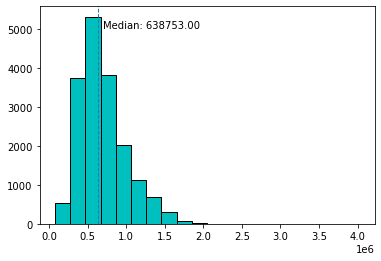

In [16]:
x = df['Est. Value']

result = plt.hist(x, bins=20, color='c', edgecolor='k')
plt.axvline(x.median(), linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(x.median()*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(x.median()))

In [17]:
3*(np.std(df['Est. Value']))

907422.6201426182

<font color="blue">3 std's of the median is over our MLS Price of 1.5M, 1.8M and above, dropped.<font>

In [18]:
df.drop(df.loc[df['Est. Value'] > 1_800_000].index, inplace=True)

<font color="blue">We will also cap 'Total Assessed Value at 1.8M'<font>

In [19]:
df.drop(df.loc[df['Total Assessed Value'] > 1_800_000].index, inplace=True)

<font color="blue">We're going to leave 'Total Assessed Value' alone. Assessments can be decades old.<font>

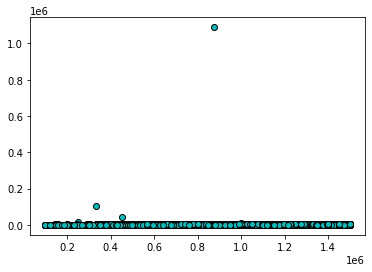

In [20]:
plt.scatter(y = df['Building Sqft'], x = df['MLS Amount'], color='c', edgecolor='k');

In [21]:
df['Building Sqft'].sort_values(ascending=False).head(20)

5940     1089000.0
21571     106000.0
11896      43560.0
7555       15647.0
7930        9000.0
7849        6731.0
8196        6040.0
11472       6021.0
10214       6003.0
6104        5779.0
10278       5697.0
10234       5500.0
4834        5482.0
7650        5481.0
6687        5372.0
7288        5312.0
6543        5307.0
9676        5300.0
8807        5270.0
11707       5200.0
Name: Building Sqft, dtype: float64

<font color="blue">All houses above 8,000 sqft will be dropped.<font>

In [22]:
df.drop(df.loc[df['Building Sqft'] > 8_000].index, inplace=True)

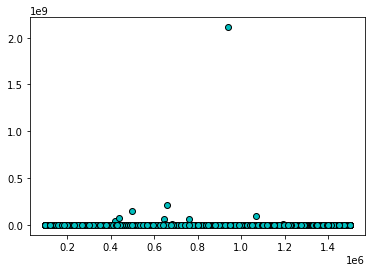

In [23]:
plt.scatter(y = df['Lot Size Sqft'], x = df['MLS Amount'], color='c', edgecolor='k');

In [24]:
df['Lot Size Sqft'].sort_values(ascending=False).head(20)

8917     2.111571e+09
8963     2.140538e+08
7332     1.468843e+08
22458    9.700812e+07
18430    7.300000e+07
17126    6.795360e+07
14622    5.797836e+07
11660    4.255812e+07
21462    8.712000e+06
17183    6.838920e+06
12198    4.619973e+06
10975    3.589106e+06
10800    3.484800e+06
10758    3.447774e+06
10706    3.377642e+06
10481    3.119252e+06
9990     2.853616e+06
9635     2.526480e+06
8295     1.904182e+06
8212     1.872209e+06
Name: Lot Size Sqft, dtype: float64

<font color="blue">We're going to cap 'Lot Size Sqft' at 5 acres, 217,800 sqft. We still want to include rural properties, but we want to limit the weight of the land on the "MLS Amount"<font>

In [25]:
df.drop(df.loc[df['Lot Size Sqft'] > 217_8000].index, inplace=True)

#### <font color="blue">Saved for Post Train/Test/Split Imputing:<font> 
#### <font color="blue">'Total Bathrooms' and 'Effective Year Built'(KNN)<font>



In [26]:
#Exporting
df.to_parquet('data/cleaned/listings_cleaned.parquet', index=False)
df.shape

(17585, 17)

##### <font color="blue">Population Data - Census Bureau<font>
---

In [27]:
pop = pd.read_csv('Data/Raw/Population.csv')

In [28]:
pop.shape

(42, 121)

In [29]:
pop.head(2)

,County,Total population,Population Under 5 years,Population 5-9 years,Population 10-14 years,Population 15-19 years,Population 20-24 years,Population 25-29 years,Population 30-34 years,Population 35-39 years,Population 40-44 years,Population 45-49 years,Population 50-54 years,Population 55-59 years,Population 60-64 years,Population 65-69 years,Population 70-74 years,Population 75-79 years,Population 80-84 years,Population Over 85 years,Population 5-14 years,Population Under 15-17 years,Population Under 18 years,Population Under 18-24 years,Population Under 15-44 years,Population Under 16 years and over,Population 18 years and over,Population 21 years and over,Population 60 years and over,Population 62 years and over,Population 65 years and over,Population 75 years and over,Median age (years),Sex ratio (males per 100 females),Old-age dependency ratio,Child dependency ratio,Percent Under 5 years,Percent 5 to 9 years,Percent 10 to 14 years,Percent 15 to 19 years,Percent 20 to 24 years,Percent 25 to 29 years,Percent 30 to 34 years,Percent 35 to 39 years,Percent 40 to 44 years,Percent 45 to 49 years,Percent 50 to 54 years,Percent 55 to 59 years,Percent 60 to 64 years,Percent 65 to 69 years,Percent 70 to 74 years,Percent 75 to 79 years,Percent 80 to 84 years,Percent 85 years and over,Percent 5 to 14 years,Percent 15 to 17 years,Percent Under 18 years,Percent 18 to 24 years,Percent 15 to 44 years,Percent 16 years and over,Percent 18 years and over,Percent 21 years and over,Percent 60 years and over,Percent 62 years and over,Percent 65 years and over,Male Total population,Percent Male Under 5 years,Percent Male 5 to 9 years,Percent Male 10 to 14 years,Percent Male 15 to 19 years,Percent Male 20 to 24 years,Percent Male 25 to 29 years,Percent Male 30 to 34 years,Percent Male 35 to 39 years,Percent Male 40 to 44 years,Percent Male 45 to 49 years,Percent Male 50 to 54 years,Percent Male 55 to 59 years,Percent Male 60 to 64 years,Percent Male 65 to 69 years,Percent Male 70 to 74 years,Percent Male 75 to 79 years,Percent Male 80 to 84 years,Percent Male 85 years and over,Female Total population,Female population Under 5 years,Female population 5 to 9 years,Female population 10 to 14 years,Female population 5 to 19 years,Female population 20 to 24 years,Female population 25 to 29 years,Female population 30 to 34 years,Female population 35 to 39 years,Female population 40 to 44 years,Female population 45 to 49 years,Female population 50 to 54 years,Female population 55 to 59 years,Female population 60 to 64 years,Female population 65 to 69 years,Female population 70 to 74 years,Female population 75 to 79 years,Female population 80 to 84 years,Female population 85 years and over,Percent Female Under 5 years,Percent Female 5 to 9 years,Percent Female 10 to 14 years,Percent Female 15 to 19 years,Percent Female 20 to 24 years,Percent Female 25 to 29 years,Percent Female 30 to 34 years,Percent Female 35 to 39 years,Percent Female 40 to 44 years,Percent Female 45 to 49 years,Percent Female 50 to 54 years,Percent Female 55 to 59 years,Percent Female 60 to 64 years,Percent Female 65 to 69 years,Percent Female 70 to 74 years,Percent Female 75 to 79 years,Percent Female 80 to 84 years,Percent Female 85 years and over
0,Alameda,1648556,88016,91575,95952,95487,89838,115618,143781,139723,121234,111042,108383,102653,99204,79002,69229,42672,25545,29602,187527,56340,331883,128985,705681,1354894,1316673,1258792,345254,303367,246050,97819,38.8,98.2,23.0,31.0,5.3,5.6,5.8,5.8,5.4,,8.7,8.5,7.4,6.7,6.6,6.2,6.0,4.8,4.2,2.6,1.5,1.8,11.4,3.4,20.1,7.8,42.8,82.2,79.9,76.4,20.9,18.4,14.9,816792,5.5,5.7,6.1,5.9,5.5,7.1,8.8,8.7,7.5,6.8,6.7,6.1,6.1,4.7,3.8,2.2,1.3,1.5,831764,43354,45027,46210,47105,45026,57614,71578,68448,60339,55336,53518,52820,49267,40914,38339,24930,14601,17338,5.2,5.4,5.6,5.7,5.4,6.9,8.6,8.2,7.3,6.7,6.4,6.4,5.9,4.9,4.6,3.0,1.8,2.1
1,Butte,208309,10910,11370,12623,16972,20154,13880,12825,12716,12722,10175,10647,14755,10300,11588,12101,7422,3993,3156,2

In [30]:
pop.dtypes

County                                  object
Total population                         int64
Population Under 5 years                 int64
Population  5-9 years                    int64
Population 10-14 years                   int64
Population 15-19 years                   int64
Population 20-24 years                   int64
Population 25-29 years                   int64
Population 30-34 years                   int64
Population 35-39 years                   int64
Population 40-44 years                   int64
Population 45-49 years                   int64
Population 50-54 years                   int64
Population  55-59 years                  int64
Population 60-64 years                   int64
Population 65-69 years                   int64
Population 70-74 years                   int64
Population 75-79 years                   int64
Population 80-84 years                   int64
Population Over 85 years                 int64
Population 5-14 years                    int64
Population Un

In [31]:
#Changing Datatypes. This row was an object. Changing to a float.

pop['Percent 25 to 29 years'].replace(to_replace=' ', value=0, inplace=True)
pop['Percent 25 to 29 years'] = pop['Percent 25 to 29 years'].astype('float64')
pop.dtypes

County                                  object
Total population                         int64
Population Under 5 years                 int64
Population  5-9 years                    int64
Population 10-14 years                   int64
Population 15-19 years                   int64
Population 20-24 years                   int64
Population 25-29 years                   int64
Population 30-34 years                   int64
Population 35-39 years                   int64
Population 40-44 years                   int64
Population 45-49 years                   int64
Population 50-54 years                   int64
Population  55-59 years                  int64
Population 60-64 years                   int64
Population 65-69 years                   int64
Population 70-74 years                   int64
Population 75-79 years                   int64
Population 80-84 years                   int64
Population Over 85 years                 int64
Population 5-14 years                    int64
Population Un

In [32]:
#Drops

#Based on the Census Dataset, this County(Humboldt) did not have any listings. It will be universally removed.
pop.drop(labels=5, axis=0, inplace = True)
pop.reset_index(drop=True, inplace = True)



In [33]:
pop.isna().sum()

County                                 0
Total population                       0
Population Under 5 years               0
Population  5-9 years                  0
Population 10-14 years                 0
Population 15-19 years                 0
Population 20-24 years                 0
Population 25-29 years                 0
Population 30-34 years                 0
Population 35-39 years                 0
Population 40-44 years                 0
Population 45-49 years                 0
Population 50-54 years                 0
Population  55-59 years                0
Population 60-64 years                 0
Population 65-69 years                 0
Population 70-74 years                 0
Population 75-79 years                 0
Population 80-84 years                 0
Population Over 85 years               0
Population 5-14 years                  0
Population Under 15-17 years           0
Population Under 18 years              0
Population Under 18-24 years           0
Population Under

In [34]:
pop.shape

(41, 121)

In [35]:
#Export Cleaned Population Data
pop.to_parquet('data/cleaned/population_cleaned.parquet', index=False)

##### <font color="blue">Income Data - Census Bureau<font>
---
<font color="blue">2021 Census. Key: W_HH = White House Hold, B_AA = Black/African American House Hold, SE = Self Employed<font>

In [36]:
income = pd.read_csv('Data/Raw/Income_Census_Data.csv')

In [37]:
income.shape

(42, 26)

In [38]:
income.head(2)

,County,W_HH_Income_<10k,"W_HH_Income_$10,000 to $14,999","W_HH_Income_$15,000 to $19,999","W_HH_Income_$20,000 to $24,999","W_HH_Income_$25,000 to $29,999","W_HH_Income_$30,000 to $34,999","W_HH_Income_$35,000 to $39,999","W_HH_Income_$40,000 to $44,999","W_HH_Income_$45,000 to $49,999","W_HH_Income_$50,000 to $59,999","W_HH_Income_$60,000 to $74,999","W_HH_Income_$75,000 to $99,999","W_HH_Income_$100,000 to $124,999","W_HH_Income_$125,000 to $149,999","W_HH_Income_$150,000 to $199,999","W_HH_Income_$200,000 or more",Median_HH_Income,Median_HH_Income_B_AA,Median_HH_Income_Asian,Median_HH_Income_White,Total_Income,Passive_Income,Active_Income,SE_Income,Non_SE_Income
0,Alameda,8196,4390,4467,3790,4459,4379,5268,4031,4554,9214,13425,23827,20314,16545,27660,63896,109729,59817,146259,126060,589180,173658,415522,73736,515444
1,Butte,3116,2692,2009,2772,3304,2121,2756,2462,2125,4222,7461,8441,4684,4557,5603,4994,64738,57410,73054,69995,81353,15432,65921,9729,71624


In [39]:
income.isna().sum()

County                              0
W_HH_Income_<10k                    0
W_HH_Income_$10,000 to $14,999      0
W_HH_Income_$15,000 to $19,999      0
W_HH_Income_$20,000 to $24,999      0
W_HH_Income_$25,000 to $29,999      0
W_HH_Income_$30,000 to $34,999      0
W_HH_Income_$35,000 to $39,999      0
W_HH_Income_$40,000 to $44,999      0
W_HH_Income_$45,000 to $49,999      0
W_HH_Income_$50,000 to $59,999      0
W_HH_Income_$60,000 to $74,999      0
W_HH_Income_$75,000 to $99,999      0
W_HH_Income_$100,000 to $124,999    0
W_HH_Income_$125,000 to $149,999    0
W_HH_Income_$150,000 to $199,999    0
W_HH_Income_$200,000 or more        0
Median_HH_Income                    0
Median_HH_Income_B_AA               5
Median_HH_Income_Asian              2
Median_HH_Income_White              0
Total_Income                        0
Passive_Income                      0
Active_Income                       0
SE_Income                           0
Non_SE_Income                       0
dtype: int64

In [40]:
income.dtypes

County                              object
W_HH_Income_<10k                     int64
W_HH_Income_$10,000 to $14,999       int64
W_HH_Income_$15,000 to $19,999       int64
W_HH_Income_$20,000 to $24,999       int64
W_HH_Income_$25,000 to $29,999       int64
W_HH_Income_$30,000 to $34,999       int64
W_HH_Income_$35,000 to $39,999       int64
W_HH_Income_$40,000 to $44,999       int64
W_HH_Income_$45,000 to $49,999       int64
W_HH_Income_$50,000 to $59,999       int64
W_HH_Income_$60,000 to $74,999       int64
W_HH_Income_$75,000 to $99,999       int64
W_HH_Income_$100,000 to $124,999     int64
W_HH_Income_$125,000 to $149,999     int64
W_HH_Income_$150,000 to $199,999     int64
W_HH_Income_$200,000 or more         int64
Median_HH_Income                     int64
Median_HH_Income_B_AA               object
Median_HH_Income_Asian              object
Median_HH_Income_White               int64
Total_Income                         int64
Passive_Income                       int64
Active_Inco

In [41]:
#Simple Conversions of Nulls

#Removing these errors so object columns can become int64, float, or null for later imputation.
income['SE_Income'].replace(to_replace='dd', value=0, inplace=True)
income['Median_HH_Income_B_AA'].replace(to_replace='-', value=0, inplace=True)
income['Median_HH_Income_B_AA'].replace(to_replace='NaN', value=0, inplace=True)
income['Median_HH_Income_Asian'].replace(to_replace='-', value=0, inplace=True)

#object converted to integer
income['Median_HH_Income_B_AA'] = income['Median_HH_Income_B_AA'].astype('float')
income['Median_HH_Income_Asian'] = income['Median_HH_Income_Asian'].astype('float')
income['SE_Income'] = income['SE_Income'].astype('float')

In [42]:
#Drops

#Dropping Humboldt County
income.drop(labels=5, axis=0, inplace = True)
income.reset_index(drop=True, inplace = True)

In [43]:
income.isna().sum()

County                              0
W_HH_Income_<10k                    0
W_HH_Income_$10,000 to $14,999      0
W_HH_Income_$15,000 to $19,999      0
W_HH_Income_$20,000 to $24,999      0
W_HH_Income_$25,000 to $29,999      0
W_HH_Income_$30,000 to $34,999      0
W_HH_Income_$35,000 to $39,999      0
W_HH_Income_$40,000 to $44,999      0
W_HH_Income_$45,000 to $49,999      0
W_HH_Income_$50,000 to $59,999      0
W_HH_Income_$60,000 to $74,999      0
W_HH_Income_$75,000 to $99,999      0
W_HH_Income_$100,000 to $124,999    0
W_HH_Income_$125,000 to $149,999    0
W_HH_Income_$150,000 to $199,999    0
W_HH_Income_$200,000 or more        0
Median_HH_Income                    0
Median_HH_Income_B_AA               5
Median_HH_Income_Asian              2
Median_HH_Income_White              0
Total_Income                        0
Passive_Income                      0
Active_Income                       0
SE_Income                           0
Non_SE_Income                       0
dtype: int64

In [44]:
income.dtypes

County                               object
W_HH_Income_<10k                      int64
W_HH_Income_$10,000 to $14,999        int64
W_HH_Income_$15,000 to $19,999        int64
W_HH_Income_$20,000 to $24,999        int64
W_HH_Income_$25,000 to $29,999        int64
W_HH_Income_$30,000 to $34,999        int64
W_HH_Income_$35,000 to $39,999        int64
W_HH_Income_$40,000 to $44,999        int64
W_HH_Income_$45,000 to $49,999        int64
W_HH_Income_$50,000 to $59,999        int64
W_HH_Income_$60,000 to $74,999        int64
W_HH_Income_$75,000 to $99,999        int64
W_HH_Income_$100,000 to $124,999      int64
W_HH_Income_$125,000 to $149,999      int64
W_HH_Income_$150,000 to $199,999      int64
W_HH_Income_$200,000 or more          int64
Median_HH_Income                      int64
Median_HH_Income_B_AA               float64
Median_HH_Income_Asian              float64
Median_HH_Income_White                int64
Total_Income                          int64
Passive_Income                  

<font color="blue">Saved for Post Train/Test/Split Imputing:<font> 
<font color="blue">'Median_HH_Income_B_AA', 'Median_HH_Income_Asian<font>


In [45]:
#Export Cleaned Income Dataset.
income.to_parquet('data/cleaned/income_cleaned.parquet', index=False)

##### <font color="blue">CA.Gov Voter Data</font>
---
<font color="blue">Voter data from General Elections in 2020 and 2022, and 2021 Gubernatorial Recall Election<font>

In [46]:
#Read in all Datasets.
V_2020 = pd.read_csv('Data/raw/GE_2020.csv')
V_2021 = pd.read_csv('Data/raw/CA_Recall_2021.csv')
V_2022 = pd.read_csv('Data/raw/GE_2022.csv')

In [47]:
V_2020.head(20)

,County,Number of,Eligible to,Registered,Precinct,Vote-By-Mail,Total,Percent of,Turnout,Turnout.1
0,NaN,Precincts,Register,Voters,Voters*,Voters,Voters,Vote-By-Mail,Registered,Eligible
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Voters,NaN,NaN
2,Alameda,521,"1,092,044","966,809","56,810","728,405","785,215",92.77%,81.22%,71.90%
3,Alpine,5,924,869,0**,749,749,100.00%,86.19%,81.06%
4,Amador*,30,"27,210","25,605","1,984","20,636","22,620",91.23%,88.34%,83.13%
5,Butte*,157,"151,237","124,793","4,125","99,510","103,635",96.02%,83.05%,68.52%
6,Calaveras*,29,"35,949","31,364","3,709","23,815","27,524",86.52%,87.76%,76.56%
7,Colusa,18,"12,388","9,807","1,778","6,272","8,050",77.91%,82.08%,64.98%
8,Contra Costa,957,"758,611","703,021","51,692","539,451","591,143",91.26%,84.09%,77.92%
9,Del Norte,18,"18,366","15,904","1,904","9,720","11,624",83.62%,73.09%,63.29%


In [48]:
#Changing Column Names and Drop Rows that were for formatting in pdf form
V_2020.rename(columns = {'Number of':'2020_#_precincts', 
                         'Eligible to':'2020_eligible_to_register',
                         'Registered':'2020_registered_voters',
                         'Precinct':'2020_precinct_voters',
                         'Vote-By-Mail':'2020_mail_voters',
                         'Total':'2020_total_voters',
                         'Percent of':'2020_%_mail_voters',
                         'Turnout':'2020_turnout_registered',
                         'Turnout.1':'2020_turnout_eligible'}, inplace = True)
V_2020 = V_2020.drop([0, 1, 60, 61], axis=0).reset_index()

V_2021.rename(columns = {'Number of':'2021_#_precincts', 
                         'Eligible to':'2021_eligible_to_register',
                         'Registered':'2021_registered_voters',
                         'Precinct':'2021_precinct_voters',
                         'Vote-By-Mail':'2021_mail_voters',
                         'Total':'2021_total_voters',
                         'Percent of':'2021_%_mail_voters',
                         'Turnout':'2021_turnout_registered',
                         'Turnout.1':'2021_turnout_eligible'}, inplace = True)
V_2021 = V_2021.drop([0, 1, 60, 61], axis=0).reset_index()

V_2022.rename(columns = {'Number of':'2022_#_precincts', 
                         'Eligible to':'2022_eligible_to_register',
                         'Registered':'2022_registered_voters',
                         'Precinct':'2022_precinct_voters',
                         'Vote-By-Mail':'2022_mail_voters',
                         'Total':'2022_total_voters',
                         'Percent of':'2022_%_mail_voters',
                         'Turnout':'2022_turnout_registered',
                         'Turnout.1':'2022_turnout_eligible'}, inplace = True)
V_2022 = V_2022.drop([0, 1, 60, 61], axis=0).reset_index()

#Dropping duplicate indices
V_2020 = V_2020.drop(['index'], axis=1)
V_2021 = V_2021.drop(['index'], axis=1)
V_2022 = V_2022.drop(['index'], axis=1)

#Cleaning County column data
V_2020['county'] = V_2020['County'].str.replace('*','')
V_2021['county'] = V_2021['County'].str.replace('*','').str.replace('2','')
V_2022['county'] = V_2022['County'].str.replace('*','')

#Based on the Census Dataset, rows from these counties will be dropped. The listings from these counties only comprised 1100/22775 rows of this dataset.
V_2020 = V_2020.loc[~((V_2020['county'] == 'Tuolumne') | (V_2020['county'] == 'Trinity') | (V_2020['county'] == 'Siskiyou') | (V_2020['county'] == 'Sierra') |
              (V_2020['county'] == 'Plumas') | (V_2020['county'] == 'Mono') | (V_2020['county'] == 'Modoc') | (V_2020['county'] == 'Mariposa') | (V_2020['county'] == 'Humboldt') |
              (V_2020['county'] == 'Lassen') | (V_2020['county'] == 'Inyo') | (V_2020['county'] == 'Glenn') | (V_2020['county'] == 'Del Norte') |
              (V_2020['county'] == 'Colusa') | (V_2020['county'] == 'Calaveras') | (V_2020['county'] == 'Amador') | (V_2020['county'] == 'Alpine'))]

V_2021 = V_2021.loc[~((V_2021['county'] == 'Tuolumne') | (V_2021['county'] == 'Trinity') | (V_2021['county'] == 'Siskiyou') | (V_2021['county'] == 'Sierra') |
              (V_2021['county'] == 'Plumas') | (V_2021['county'] == 'Mono') | (V_2021['county'] == 'Modoc') | (V_2021['county'] == 'Mariposa') | (V_2021['county'] == 'Humboldt') |
              (V_2021['county'] == 'Lassen') | (V_2021['county'] == 'Inyo') | (V_2021['county'] == 'Glenn') | (V_2021['county'] == 'Del Norte') |
              (V_2021['county'] == 'Colusa') | (V_2021['county'] == 'Calaveras') | (V_2021['county'] == 'Amador') | (V_2021['county'] == 'Alpine'))]

V_2022 = V_2022.loc[~((V_2022['county'] == 'Tuolumne') | (V_2022['county'] == 'Trinity') | (V_2022['county'] == 'Siskiyou') | (V_2022['county'] == 'Sierra') |
              (V_2022['county'] == 'Plumas') | (V_2022['county'] == 'Mono') | (V_2022['county'] == 'Modoc') | (V_2022['county'] == 'Mariposa') | (V_2022['county'] == 'Humboldt') |
              (V_2022['county'] == 'Lassen') | (V_2022['county'] == 'Inyo') | (V_2022['county'] == 'Glenn') | (V_2022['county'] == 'Del Norte') |
              (V_2022['county'] == 'Colusa') | (V_2022['county'] == 'Calaveras') | (V_2022['county'] == 'Amador') | (V_2022['county'] == 'Alpine'))]

#Moving County into first column position
first = V_2020.pop('County')
V_2020.insert(0, 'County', first)

#Dropping County columns from other datasets for concatenation
V_2020.drop(['county'], axis=1, inplace = True)
V_2021.drop(['County', 'county'], axis=1, inplace = True)
V_2022.drop(['County', 'county'], axis=1, inplace = True)

/var/folders/3j/my4n0ykx0yb51nj_xv6qbxp40000gn/T/ipykernel_26283/3536938576.py:41: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  V_2020['county'] = V_2020['County'].str.replace('*','')
/var/folders/3j/my4n0ykx0yb51nj_xv6qbxp40000gn/T/ipykernel_26283/3536938576.py:42: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  V_2021['county'] = V_2021['County'].str.replace('*','').str.replace('2','')
/var/folders/3j/my4n0ykx0yb51nj_xv6qbxp40000gn/T/ipykernel_26283/3536938576.py:43: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  V_2022[

In [49]:
#Merging datasets.

Vote = pd.concat([V_2020, V_2021, V_2022], axis=1).reset_index()
Vote.drop(['index'], axis=1, inplace = True)

In [50]:
#Removing symbols from columns.

Vote = Vote.apply(lambda x: x.str.replace(',', ''))
Vote = Vote.apply(lambda x: x.str.replace('%', ''))
Vote = Vote.apply(lambda x: x.str.replace('*', ''))

#Converting % columns to floats
Vote[['2020_%_mail_voters', '2020_turnout_registered', '2020_turnout_eligible', '2021_%_mail_voters', '2021_turnout_registered', 
      '2021_turnout_eligible', '2022_%_mail_voters', '2022_turnout_registered', '2022_turnout_eligible']] = Vote[['2020_%_mail_voters',
                                                                                                                  '2020_turnout_registered', '2020_turnout_eligible', '2021_%_mail_voters', 
                                                                                                                  '2021_turnout_registered','2021_turnout_eligible', '2022_%_mail_voters', 
                                                                                                                  '2022_turnout_registered', '2022_turnout_eligible']].astype(float)/100
#Convert rest of columns
Vote = Vote.apply(pd.to_numeric, errors='ignore')

/var/folders/3j/my4n0ykx0yb51nj_xv6qbxp40000gn/T/ipykernel_26283/1495682737.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Vote = Vote.apply(lambda x: x.str.replace('*', ''))


In [51]:
Vote.shape

(41, 28)

In [52]:
#Export Cleaned CA.GOV Voter Data
Vote.to_parquet('data/cleaned/vote_cleaned.parquet', index=False)